# Importing

In [1]:
import pandas as pd
import rdkit
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
#from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression

# Reading data


In [2]:
data_raw = pd.read_csv('tested_molecules.csv')

# Calculating descriptors

In [3]:
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles) #string to molecule object
    descriptors = {}
    for name, func in Descriptors.descList:
        descriptors[name] = func(mol)
    return descriptors


descriptor_data =data_raw['SMILES'].apply(calc_descriptors) #blabla kijk ff chatgpt, willen we losse df of dit als rij? vgm asl rij, check ff Evi's versie 

# Adding data to a dataframe

In [4]:
df_molecules = pd.DataFrame(data_raw['SMILES']) #create a new dataframe for the smiles and descriptors

df_descriptors=pd.DataFrame(descriptor_data.tolist()) #making a dataframe for the descriptor data

df_molecules = pd.concat([df_molecules, df_descriptors], axis=1)

df_molecules.head()


,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C=C(C)c1nc(N)nc(N)n1,5.313889,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,142.101,151.085795,...,0,0,0,0,0,0,0,0,0,0
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,11.238954,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,239.593,250.039672,...,0,0,0,0,0,0,0,0,0,0
2,C=CCNC(=O)CCCC(=O)NCC=C,11.090706,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,192.133,210.136828,...,0,0,0,0,0,0,0,0,0,0
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,11.892238,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,220.143,232.084792,...,0,0,0,0,0,0,0,0,0,0
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,11.693580,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,215.575,226.050905,...,0,0,0,0,0,0,0,0,0,0


# Splitting and scaling the descriptors

In [5]:
# For the filters to work it is better if all data is standardized so we will make a copy so we don't lose the actual values

df_molecules_copy = df_molecules.copy()
df_descriptors=df_molecules_copy.drop(columns=['SMILES'])
# We do not want to standardize binary columns, so we need to seperate these from the other columns
binary_columns = []#list of names of the binary columns
non_binary_columns=[]

for column in df_descriptors.columns:
    if df_molecules_copy[column].nunique() == 2 and df_descriptors[column].min() == 0 and df_descriptors[column].max() == 1:
        binary_columns.append(column)
    elif column not in binary_columns:
        non_binary_columns.append(column)

print(binary_columns)
print(non_binary_columns)

#oke sklearn wilde t opeens niet doen in deze environment, maar rdkit niet in de ander, vanaf hier kan ik mijn code dus neit meer testen, ik hoop dat ie t doet bij jullie, anders lmk :))
binary_descriptors=df_descriptors[binary_columns]
non_binary_descriptors=df_descriptors[non_binary_columns]

scaler = StandardScaler()
standardized_non_binary_cols=pd.DataFrame(scaler.fit_transform(non_binary_descriptors),
                                                   columns=non_binary_columns)

#put the binary columns together with the standardized non binary columns
df_standardized_descriptors = pd.concat([standardized_non_binary_cols, binary_descriptors], axis=1) #put the binary columns together with the standardized non binary columns




['fr_Al_COO', 'fr_C_S', 'fr_Imine', 'fr_barbitur', 'fr_dihydropyridine', 'fr_guanido', 'fr_lactam', 'fr_lactone', 'fr_nitro', 'fr_nitro_arom', 'fr_oxazole', 'fr_priamide']
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_

# Applying filters

In [6]:
#Low variance filter:
var_filter = VarianceThreshold(threshold=0.001)
X_var_filtered = var_filter.fit_transform(df_standardized_descriptors)
df_filtered_once_descriptors = pd.DataFrame(X_var_filtered, columns=df_standardized_descriptors.columns[var_filter.get_support()])


# High-correlation filter
# Calculate the correlation matrix
corr_matrix = df_filtered_once_descriptors.corr().abs()

# Flatten the correlation matrix to get unique pairs of columns
corr_values = corr_matrix.unstack()

# Drop the diagonal values (correlation of a feature with itself)
corr_values = corr_values.drop(labels=corr_matrix.columns)

# Get pairs of columns with correlation greater than the threshold (e.g., 0.9)
highly_correlated_pairs = corr_values[corr_values > 0.95].index.tolist()

# Extract unique columns from the pairs
to_drop = set()
for pair in highly_correlated_pairs:
    to_drop.add(pair[0])  # Add the first column of the pair
    to_drop.add(pair[1])  # Add the second column of the pair (both need to be dropped since correlation is the same both ways)

# Drop highly correlated columns from the filtered descriptors DataFrame
df_filtered_twice_descriptors = df_filtered_once_descriptors.drop(columns=to_drop)


# We zouden evt nog PCA kunnen doen? Ik weet ff neit of dat hierbij nu nut heeft of niet




# Getting filtered columns from original data

In [7]:
#OKay nu hebben we een df die gefilterd is, maar met standardized waarden, we willen t origineel hebben dus we moeten die kolommen eruit halen:
relevant_columns=['SMILES']
filtered_descriptors=list(df_filtered_twice_descriptors.columns)

for column in filtered_descriptors:
    relevant_columns.append(column)


df_filtered_molecules=df_molecules[relevant_columns]
df_filtered_molecules # dit is de output met smiles en dan de descriptors die relevant zijn


#test mocht sklearn het ooit doen:
#descriptors_left=list(df_filtered_molecules.columns)
#print(descriptors_left)

,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_urea,fr_Al_COO,fr_C_S,fr_Imine,fr_barbitur,fr_dihydropyridine,fr_guanido,fr_lactone,fr_oxazole,fr_priamide
0,C=C(C)c1nc(N)nc(N)n1,5.313889,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,142.101,151.085795,...,0,0,0,0,0,0,0,0,0,0
1,C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,11.238954,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,239.593,250.039672,...,0,0,0,0,0,0,0,0,0,0
2,C=CCNC(=O)CCCC(=O)NCC=C,11.090706,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,192.133,210.136828,...,0,0,0,0,0,0,0,0,0,0
3,C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,11.892238,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,220.143,232.084792,...,0,0,0,0,0,0,0,0,0,0
4,C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,11.693580,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,215.575,226.050905,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,O=C1c2ccccc2[C@H](Nc2ccc3c(c2)OCCO3)N1Cc1ccco1,12.955843,12.955843,0.016627,-0.290408,0.764433,17.703704,362.385,344.241,362.126657,...,0,0,0,0,0,0,0,0,0,0
1112,O=S(=O)(Nc1cccc(-c2cn3ccsc3[nH+]2)c1)c1ccc(F)cc1,12.983770,12.983770,0.009487,-3.772852,0.594812,11.720000,374.442,361.338,374.042773,...,0,0,0,0,0,0,0,0,0,0
1113,Oc1c(C[NH+]2CCN(c3ccccn3)CC2)cc(Cl)c2cccnc12,10.579691,10.579691,0.249681,0.249681,0.753119,15.640000,355.849,335.689,355.132015,...,0,0,0,0,0,0,0,0,0,0
1114,c1ccc(-c2csc(N3CCN(c4ccccn4)CC3)n2)cc1,4.812249,4.812249,0.983396,0.983396,0.738254,14.956522,322.437,304.293,322.125218,...,0,0,0,0,0,0,0,0,0,0


# Applying PCA

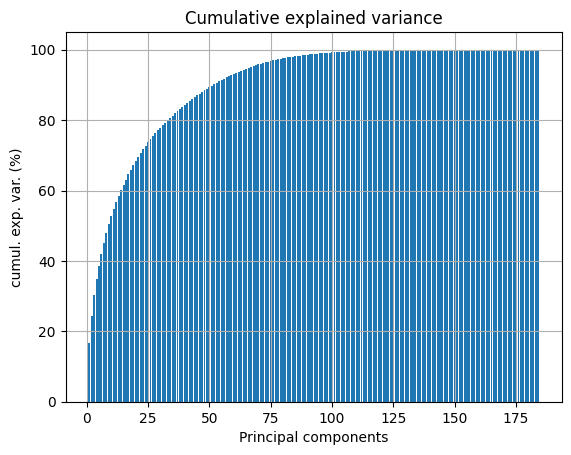

Number of principle components needed to cover 65% of the data: 18


In [8]:
X = df_filtered_molecules.drop(columns=['SMILES'])  # Looking at all the descriptors
y_PKM = data_raw['PKM2_inhibition']    # Comparing the PKM2 inhibition to the descriptors
y_ERK = data_raw['ERK2_inhibition']     # Comparing the ERK2 inhibition to the descriptors

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)
variance = pca.explained_variance_ratio_

# Summing the variance and transforming to a percentage
cumulative_variance = np.cumsum(variance)*100

# Plotting the cumulative explained variance in a barplot
plt.bar(x=list(range(1,len(cumulative_variance)+1)), height=cumulative_variance)

# Setting the title and labels
plt.title("Cumulative explained variance")
plt.xlabel("Principal components")
plt.ylabel("cumul. exp. var. (%)")
plt.grid(True)
plt.show()

# Deciding how many principle components are needed to cover 65% of the data 
n_principle_components = 0
variance = cumulative_variance[n_principle_components]
while variance <= 65: 
    n_principle_components += 1 
    variance = cumulative_variance[n_principle_components]
n_principle_components += 1  # Count 1 with the number of principle components, since the first index is 0 in stead of 1 
print('Number of principle components needed to cover 65% of the data:', n_principle_components)  


In [9]:
# # Finding the electrode with the highest load for PC1
# descriptors_pc1 = pca.components_[0]
# abs_descriptors_pc1 = abs(descriptors_pc1)
# max_index_pc1 = np.argmax(abs_descriptors_pc1)+1
# print(df_filtered_molecules.columns[max_index_pc1], "is the descriptor with the highest load for PC1")

In [10]:
# # Maak een DataFrame van de loadings
# loadings = pca.components_
# loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=X.columns)

# # Sorteer elektroden op absolute loadings voor PC1
# sorted_pc1 = loading_df['PC1'].abs().sort_values(ascending=False)
# # Sorteer elektroden op absolute loadings voor PC2
# sorted_pc2 = loading_df['PC2'].abs().sort_values(ascending=False)

# # Selecteer de top elektroden met hoogste absolute loadings voor PC2
# top_descriptors_pc2 = sorted_pc2.index[:10]
# # Selecteer de top elektroden met hoogste absolute loadings voor PC1
# top_descriptors_pc1 = sorted_pc1.index[:10]

# print(top_descriptors_pc1)

In [38]:
# Maak een DataFrame van de loadings
loadings = pca.components_
loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=X.columns)

# Sorteer elektroden op absolute loadings voor PC1
sorted_pc1 = loading_df['PC1'].abs().sort_values(ascending=False)
# Sorteer elektroden op absolute loadings voor PC2
sorted_pc2 = loading_df['PC2'].abs().sort_values(ascending=False)

# Selecteer de top elektroden met hoogste absolute loadings voor PC2
top_descriptors_pc2 = sorted_pc2.index[:10]
# Selecteer de top elektroden met hoogste absolute loadings voor PC1
top_descriptors_pc1 = sorted_pc1.index[:10]

PC_list = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18']
top_descriptors = {}
for PC in PC_list:
    sorted_PC = loading_df[PC].abs().sort_values(ascending=False)
    top_descriptors_PC = sorted_PC.index[:5]
    for descriptor in top_descriptors_PC:
        if descriptor in top_descriptors:
            top_descriptors[descriptor] += 1
        else:
            top_descriptors[descriptor] = 1
top_descriptors = dict(sorted(top_descriptors.items(), key=lambda item: item[1], reverse=True))
i=0

# Print the top descriptors for PC1-PC18
print('Top descriptors for PC1-PC18:')
print('Nr.    Count     Descriptor'	)
for descriptor in top_descriptors:
    if top_descriptors[descriptor] > 3:
        i+=1
        print(i, "      ", top_descriptors[descriptor], '     ', descriptor)


Top descriptors for PC1-PC18:
Nr.    Count     Descriptor
1        7       EState_VSA6
2        6       EState_VSA4
3        6       PEOE_VSA6
4        4       TPSA
5        4       EState_VSA7
6        4       VSA_EState1
7        4       BCUT2D_MWHI
8        4       PEOE_VSA9
9        4       PEOE_VSA7
10        4       EState_VSA3
11        4       EState_VSA8


Component 1: Top 5 descriptors indices and loadings:
                     loading  absolute_loadings
Ipc             1.000000e+00       1.000000e+00
BertzCT         3.895880e-07       3.895880e-07
MolWt           1.284385e-07       1.284385e-07
ExactMolWt      1.284210e-07       1.284210e-07
HeavyAtomMolWt  1.196601e-07       1.196601e-07

Component 2: Top 5 descriptors indices and loadings:
                 loading  absolute_loadings
BertzCT         0.910131           0.910131
MolWt           0.221508           0.221508
ExactMolWt      0.221352           0.221352
HeavyAtomMolWt  0.212754           0.212754
LabuteASA       0.091470           0.091470

Component 3: Top 5 descriptors indices and loadings:
                      loading  absolute_loadings
MolWt                0.486877           0.486877
ExactMolWt           0.485841           0.485841
HeavyAtomMolWt       0.435970           0.435970
BertzCT             -0.384932           0.384932
NumValenceElectrons  0.182915           0.

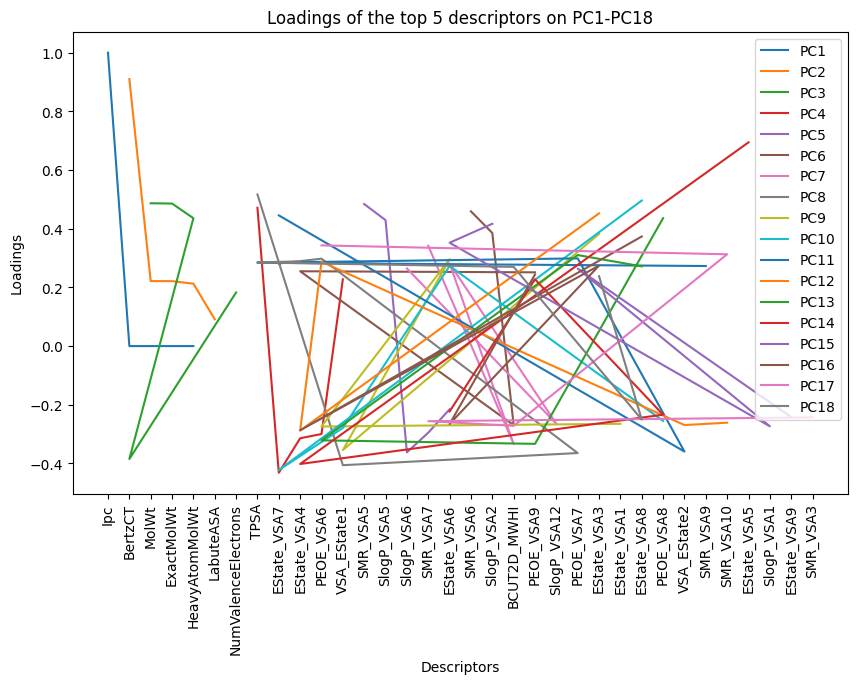

In [60]:
pca = PCA(n_components=n_principle_components)
pca.fit(X)

fig = plt.figure(figsize=(10, 6))
# Doorloop de componenten
for i in range(n_principle_components):
    loadings_pc = pd.DataFrame(pca.components_[i], columns=['loading'], index=X.columns)
    loadings_pc['absolute_loadings'] = loadings_pc['loading'].abs()

    # Sort loadings with descriptor with highest loading first 
    loadings_pc_sorted = loadings_pc.sort_values(by='absolute_loadings', ascending=False)
    top_5_descriptors = loadings_pc_sorted.head(5)

    # Plotting the loadings on PC1 and PC2 compared
    plt.plot(top_5_descriptors['loading'], label=f'PC{i+1}')
    filtered_loadings = loadings_pc.loc[top_descriptors.keys()]
    # plt.plot(filtered_loadings['loading']) #, label='PC{i}'
    
    
    # Print top 5 descriptors 
    
    print(f"Component {i+1}: Top 5 descriptors indices and loadings:\n{top_5_descriptors}\n")

# Plotting the loadings on PC1-PC18
plt.title('Loadings of the top 5 descriptors on PC1-PC18')
plt.xlabel('Descriptors')
plt.ylabel('Loadings')
plt.xticks(rotation=90)
# plt.xticks(range(len(top_descriptors.keys())),top_descriptors, rotation=90)
plt.legend()
plt.show()

In [39]:
# Plotting the loadings on PC1 and PC2 compared
plt.plot(data=loadings_pc1, marker='o', label='PC1')
plt.plot(data=loadings_pc2, marker='o', label='PC2')

# Setting the title and labels
plt.title("Loadings on PC1 and PC2")
plt.xlabel("Electrodes")
plt.ylabel("Loading")
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'line'

# Random Forest Regressor for importances

In [12]:
# model = RandomForestRegressor()   # Using a random forest regressor to get the importances of the descriptors

# model.fit(X, y_ERK)    # Fitting the model to the PKM2 inhibition data

# ranking = {}
# for i in range(20):   # Running the model 20 times to get a better estimate of the importances
#     importances = model.feature_importances_    # Getting the importances of the descriptors
#     indices = np.argsort(importances)[::-1]    # Sorting the importances in descending order
#     for f in range(X.shape[1]): 
#         if X.columns[indices[f]] not in ranking:
#             ranking[X.columns[indices[f]]] = importances[indices[f]]    # Adding the importances of the descriptors to a dictionary
#         ranking[X.columns[indices[f]]] += importances[indices[f]]       # updating the importances of the descriptors in a dictionary

# print("Feature ranking:")
# for f in range(len(ranking.keys())):
#     print(f"{f + 1}. feature {list(ranking.keys())[f]} ({list(ranking.values())[f]})")  # Printing the importances of the descriptors
    

# Visualize the feature ranking

In [13]:
# # Visualize the most important descriptors
# plt.figure(figsize=(12, 8))
# plt.title("Feature Importances")
# plt.bar(range(X.shape[1])[:20], importances[indices][:20], align='center')  # Plot the first 20 features
# plt.xticks(range(20), X.columns[indices][:20], rotation=90)  # Put labels on the x-axis
# plt.xlabel("Descriptors")
# plt.ylabel("Importance")
# plt.tight_layout()
# plt.show()

# Plotting the 2 most important descriptors

In [14]:
# # Create a color array based on the condition
# colors = ['red' if inhibition == 1 else 'blue' for inhibition in data_raw["ERK2_inhibition"]]

# # Plot the data points with the specified colors
# plt.figure(figsize=(10, 6))
# plt.scatter(df_filtered_molecules['NumAromaticRings'], df_filtered_molecules['NumValenceElectrons'], c=colors, edgecolor='k')    
# plt.xlabel("MolLogP")
# plt.ylabel("BCUT2D_MWHI")
# plt.title("Scatter Plot of MolLogP vs BCUT2D_MWHI")
# plt.show()

# Chi-square for importances

In [15]:
# df_molecules = pd.read_csv('tested_molecules.csv')
# df_descriptors = pd.read_csv('filtered_molecules.csv')

# X = df_descriptors.drop(columns=['SMILES'])  # Looking at all the descriptors
# y_PKM = df_molecules['PKM2_inhibition']    # Comparing the PKM2 inhibition to the descriptors
# y_ERK = df_molecules['ERK2_inhibition']     # Comparing the ERK2 inhibition to the descriptors

# def getFeature(mask):   # Function to get the features that are selected by the SelectKBest function
#     new_features = [] # The list of your K best features

#     for bool, feature in zip(mask, X.columns):
#         if bool:
#             new_features.append(feature)
            
#     return new_features

# X_norm = MinMaxScaler().fit_transform(X)
# chi_selector = SelectKBest(chi2, k=4)       # Change the k value to the number of features you want to select
# chi_selector.fit(X_norm, y_ERK)     # Change y_PKM to y_ERK if you want to see the features for ERK2 inhibition
# chi_features = getFeature(chi_selector.get_support())   # Getting the features that are selected by the SelectKBest function
# chi_features

# f_regression_selector = SelectKBest(f_regression, k=30)       # Change the k value to the number of features you want to select
# f_regression_selector.fit(X_norm, y_ERK)     # Change y_PKM to y_ERK if you want to see the features for ERK2 inhibition
# f_regression_selector = getFeature(f_regression_selector.get_support())   # Getting the features that are selected by the SelectKBest function
# f_regression_selector 

# Outlier analysis

In [16]:
z_scores = stats.zscore(df_descriptors)

threshold = 0.5
outlier = np.abs(z_scores) > threshold
df_outliers = binary_descriptors[outlier]
df_outliers = df_outliers.dropna(how='all')
df_outliers.head()

,fr_Al_COO,fr_C_S,fr_Imine,fr_barbitur,fr_dihydropyridine,fr_guanido,fr_lactam,fr_lactone,fr_nitro,fr_nitro_arom,fr_oxazole,fr_priamide
17,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
47,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Fingerprints

In [17]:
PandasTools.AddMoleculeColumnToFrame(df_molecules, smilesCol='SMILES', includeFingerprints=True) # dit zou voor fingerprints moeten zorgen maar bij mij doet pandatools het niet:(

NameError: name 'PandasTools' is not defined

# Create a csv file

In [ ]:
df_descriptor_molecules = df_filtered_molecules[top_descriptors_pc2]
pd.DataFrame.to_csv(df_descriptor_molecules, 'descriptors.csv') 
